In [2]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [4]:
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=100.0, fy=100.0,
    cx=100.0, cy=100.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 224, 1024)


In [98]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.4, 0.05]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)


importance_jit = jax.jit(b.genjax.model.importance)
update_jit = jax.jit(b.genjax.model.update)

In [99]:
def get_depth_image(image):
    mval = image[image < image.max()].max()
    return b.get_depth_image(image, max=mval)

In [100]:
CHEESEITZ_BOX_IDX = 1
FORK_IDX = 17 # XXX
SPOON_IDX = 17 # XXX

In [113]:
CHEESEITZ_BOX_CONTACT_PARAMS = [0.0, 0.2, 0.0]

In [114]:
SHIFT_MIN = -0.1
SHIFT_SCALE = 0.5

In [115]:
def fork_spoon_generator(key):
    is_fork = jax.random.bernoulli(key)
    shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(key)

    indices = jnp.array([21, CHEESEITZ_BOX_IDX, FORK_IDX if is_fork else SPOON_IDX])

    box_dims = b.RENDERER.model_box_dims[indices]
    root_poses = jnp.array([table_pose, table_pose, table_pose])
    parents = jnp.array([-1, 0, 0])
    contact_params = jnp.array([[0.0, 0.0, 0.0],
                                [*CHEESEITZ_BOX_CONTACT_PARAMS],
                                [shift, 0.0, 0.0]])
    faces_parents = jnp.array([0, 2, 2])
    faces_child = jnp.array([0, 3, 3])
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)
    camera_pose = jnp.eye(4)
    rendered = b.RENDERER.render(
        jnp.linalg.inv(camera_pose) @ poses , indices
    )[...,:3]
    return (is_fork, rendered)

In [116]:
key = jax.random.PRNGKey(0)

In [117]:
is_fork_img, img = fork_spoon_generator(key)

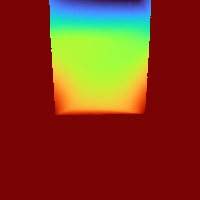

In [118]:
get_depth_image(img[:, :, 2])